门控循环单元公式：
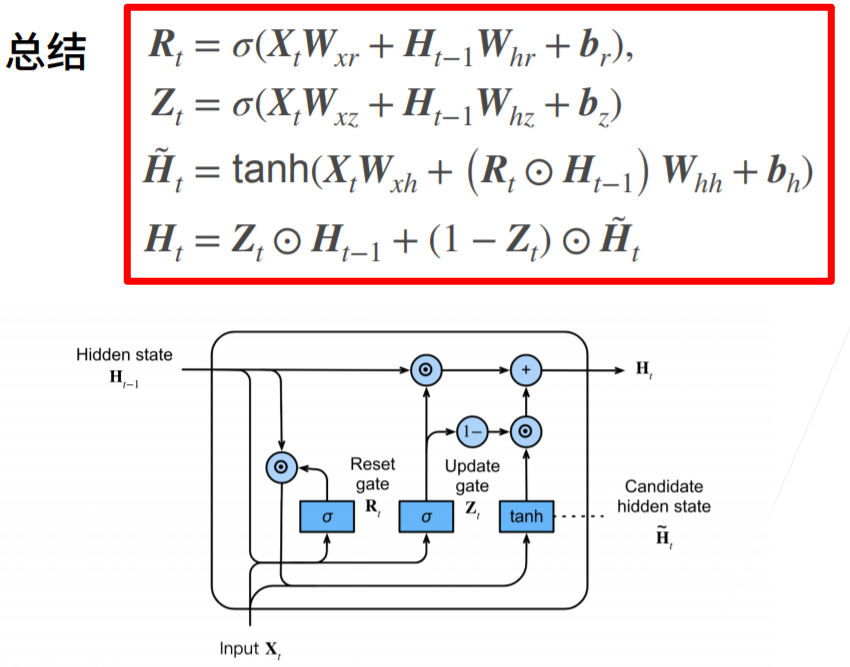

# GRU从零实现：

In [3]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35 # num_steps为时间序列的长度
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps) # 得到训练迭代器和字典

初始化模型参数

In [4]:
def get_params(vocab_size, num_hiddens, device): # 初始化模型的参数
    num_inputs = num_outputs = vocab_size # 输入特征，输出类别数（因为这里的语言模型，就是给出一个token，预测下一个词出现的概率，因此，就相当于vocab_size个类别的分类）

    def normal(shape): # 给定形状，使用 均值为0，方差为1的 正态分布，最后还乘了0.01,相当于把参数往0.01拉了（方差变成了0.01）
        return torch.randn(size=shape, device=device) * 0.01

    def three(): # 初始化：更新门，重置门，和候选隐藏状态的参数，一共9个
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()
    W_xr, W_hr, b_r = three()
    W_xh, W_hh, b_h = three()
    
    # 下面是隐藏状态的参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params: # 设置 可训练
        param.requires_grad_(True)
    return params

定义隐藏状态的初始化函数

In [5]:
def init_gru_state(batch_size, num_hiddens, device): # [B, H]
    return (torch.zeros((batch_size, num_hiddens), device=device),)

定义门控循环单元模型

In [6]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z) # 更新门
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r) # 重置门
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h) # 候选隐藏状态
        H = Z * H + (1 - Z) * H_tilda # 影藏状态
        Y = H @ W_hq + b_q # 输出，相比隐藏状态，这里其实就是加了一个全连接层而已
        outputs.append(Y) # 把每个时刻的输出，放入一个列表
    return torch.cat(outputs, dim=0), (H,) # 第一个参数：把每个时刻的输出，在0维，也就是时间维度拼接起来；第二个参数：最后一个隐藏状态

训练

perplexity 1.1, 37952.1 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


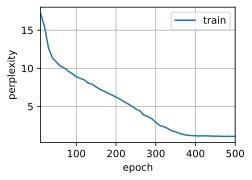

In [7]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu() # 字典大小（总的序列长度）、隐藏状态大小、设备
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# GRU的简洁实现

perplexity 1.0, 427245.8 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


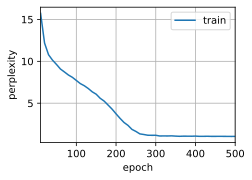

In [8]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens) # 调用nn.GRU即可：输入大小、隐藏状态大小
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)